# Week 6. Logistic Regression & k-Nearest Neighbors

## 0. Load data

In [1]:
import numpy as np
import pandas as pds

import matplotlib as MP
from matplotlib import pyplot as plt
import seaborn as sbn

data = pds.read_csv('../files/week06/Week 06. data-wine-red.csv',
    delimiter=';'
)

data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [2]:
data.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

For logistic regression, we prepare to binary dataset.

In [4]:
# 5 초과인 경우 1, 5 이하인 경우 0으로 binary data로 변환
binary_data = data.copy()
binary_data['quality'] = binary_data['quality'].apply(lambda x: 1 if x > 5 else 0)

binary_data.quality.value_counts()

1    855
0    744
Name: quality, dtype: int64

## 1-1. Logistic regression
-----------------
베르누이 분포에 따르면, 타겟 Y의 분포를 다음과 같은 문자로 쓸 수 있습니다. 

$$ P(Y=1) = p, \  P(Y=0) = q = 1-p $$

그리고 확률 p와 q의 관계를 $odds(p,q)$ 함수로 표현합니다. 

$$odds(p,q) = \frac{p}{q} = \frac{p}{1-p} $$

In [5]:
def fn_log_odds(p):
    return np.log( fn_odds(p) )

def fn_odds(p):
    return (p + 1e-8) / (1 - p + 1e-8)

In [6]:
ps = np.arange(0, 1, 1e-3)

odds = fn_odds(ps)

log_odds = fn_log_odds(ps)

C:\Users\keb20\AppData\Local\Temp/ipykernel_45328/1371162317.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


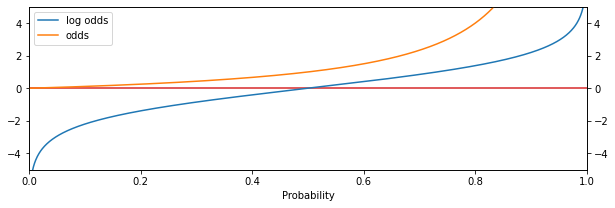

In [7]:
fig, ax = plt.subplots(1,1, figsize = (10, 3))

ax.axhline(0, color = 'tab:red')

ax.plot(ps, log_odds)
ax.set_ylim(-5, 5)
ax.set_xlim(0, 1)

tax = ax.twinx()
tax.plot(ps, odds, color = 'tab:orange')
tax.set_ylim(-5, 5)

ax.legend(
    [
        MP.lines.Line2D([],[],color = 'tab:blue'),
        MP.lines.Line2D([],[],color = 'tab:orange'),
    ], 
    [
        'log odds',
        'odds'
    ])

ax.set_xlabel('Probability')
fig.show()

<img src = https://imgur.com/vZHCF9X.png width = 700>

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

In [9]:
# quality를 측정하기 위한 모델이기 때문에 x, y로 나누어줌
x = binary_data.drop(columns = 'quality')
y = binary_data.quality

## 1-2. Visualizing Performance 

지난 시간에 실습한 코드를 다시 활용하겠습니다. 

k fold로 데이터를 교차검증하며, 각 fold마다 스케일링을 적용할 수 있도록 코드를 수정하겠습니다. 

이후 분할된 데이터들을 활용하여 logistic regression을 수행하고 결과를 분석해보려합니다. 

In [10]:
from itertools import product
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

def ss_kfold_fn(data, scaling = True):
    kf = KFold()
    for n, (train_idx, valid_idx) in enumerate(kf.split(data)):
        
        scaler_x = StandardScaler()
        
        if scaling:
            train_x = scaler_x.fit_transform(data.iloc[train_idx].drop(columns = 'quality'))
            valid_x = scaler_x.transform(data.iloc[valid_idx].drop(columns = 'quality'))
            
        else:
            train_x = data.iloc[train_idx].drop(columns = 'quality').values
            valid_x = data.iloc[valid_idx].drop(columns = 'quality').values

        train_y = data.iloc[train_idx]['quality'].values.reshape(-1,1)
        valid_y = data.iloc[valid_idx]['quality'].values.reshape(-1,1)
        
        yield [
            [train_x, train_y],
            [valid_x, valid_y]
        ], (scaler_x)


scalers = []
valid_y_hat = []
valid_y = []
for (train_set, valid_set), scaler in ss_kfold_fn(binary_data):
    scalers.append(scaler) # 데이터 스케일을 저장해줌
    model.fit(train_set[0], train_set[1].ravel()) # 학습
    valid_y.append(valid_set[1].squeeze())
    valid_y_hat.append(model.predict_proba(valid_set[0]).squeeze())
    


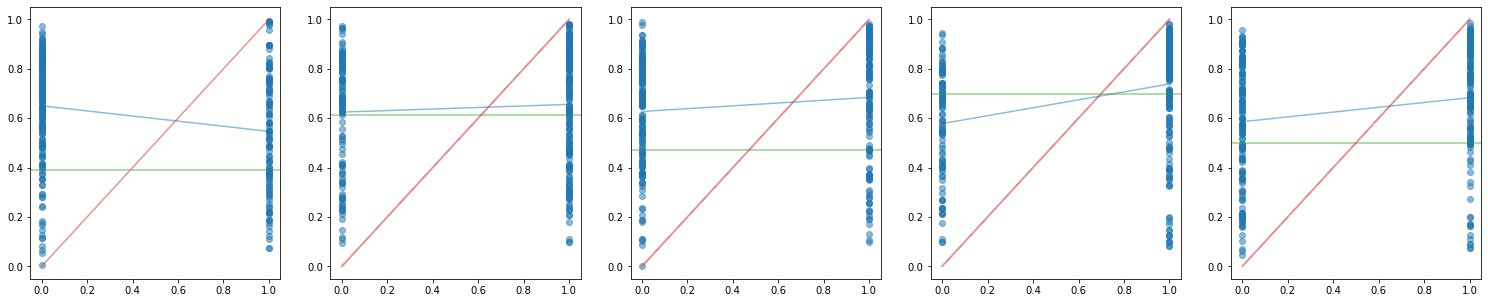

In [11]:
# 파란색이 예측된 값의 평균, 녹색이 샘플의 평균, 빨간 선은 x = y
# 녹색과 파란색이 비슷할 수록 실제 분포와 비슷한 것
# 4번째 set이 괜찮은 결과
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,5, figsize = (26, 5))

for n, (yt, yp) in enumerate(zip(valid_y, valid_y_hat)):
    
    yp_prob = np.array([ypv[ytv] for ytv, ypv in zip(yt, yp)])

    # yt : y_true, yp_prob : y_probability 각각 x축, y축으로 scatter
    ax[n].scatter(yt, yp_prob, alpha = .5)
    ax[n].plot(yt,yt, color = 'tab:red', alpha = .5)
    ax[n].plot([0,1],[yp_prob[yt == 0].mean(),yp_prob[yt == 1].mean()], color = 'tab:blue', alpha = .5)
    ax[n].axhline(yt.mean(), color = 'tab:green', alpha = .5)

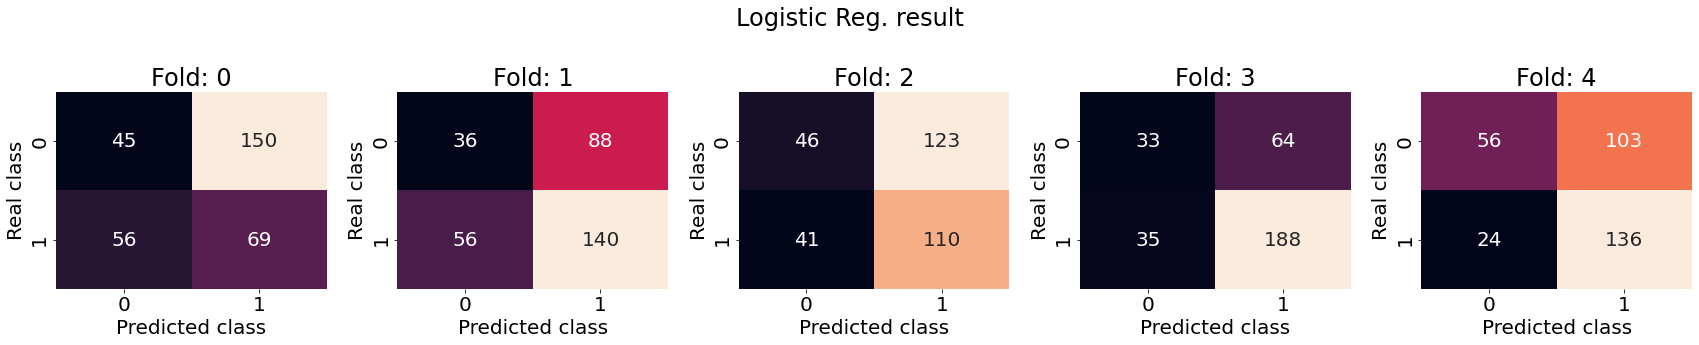

In [12]:
# 결과 시각화 : confusion metrix, 빈도수
def vis_clf(yt, yp):

    round_yp = yp.round()
    match_matrix = np.zeros((2,2))
    for y_true_value, y_pred_value in product(range(2), range(2)):

        count_value = ((yt == y_true_value) & (round_yp == y_pred_value)).sum()
        match_matrix[y_true_value, y_pred_value] += count_value

    return match_matrix

plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,5,figsize = (24,5))

for n, (yt, yp) in enumerate(zip(valid_y, valid_y_hat)):
    
    yp_prob = np.array([ypv[ytv] for ytv, ypv in zip(yt, yp)])

    matrix = vis_clf(yt, yp_prob)
    sbn.heatmap(matrix, ax = ax[n], cbar = False, annot = matrix, fmt = '.0f')
    ax[n].set_title(f'Fold: {n}')
    ax[n].set_ylabel('Real class')
    ax[n].set_xlabel('Predicted class')

fig.suptitle('Logistic Reg. result')    
fig.tight_layout()


## 2. $k$-Nearest Neighbors
-----------------


<img src = https://imgur.com/RGi3Bn7.png width = 700>

<img src = https://imgur.com/dsfOeu7.png width = 700>

---------------------
<img src = https://imgur.com/EMd0lDv.png width = 500>

## 2-1. $k$-Nearest Neighbors with toy datasets


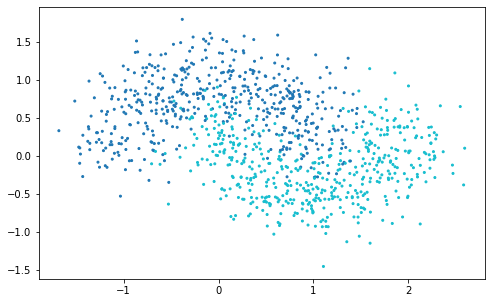

In [13]:

from sklearn.datasets import make_moons

plt.rcParams['font.size'] = 10
# random_state 고정
X, y = make_moons(n_samples = 1000, noise = .3, random_state = 2022)
toy_data = pds.DataFrame(
    np.concatenate([X,y[:, np.newaxis]], 1),
    columns = ['x1','x2','y']
)

fig,ax = plt.subplots(figsize = (8,5))
ax.scatter(data = toy_data, x = 'x1', y = 'x2', c = 'y', cmap = 'tab10', s = 4)


In [14]:
from sklearn.model_selection import KFold

kf = KFold(shuffle=True, random_state = 2022)
toy_iter_index = next(kf.split(toy_data))

train_x, train_y = toy_data.iloc[toy_iter_index[0], :-1].values, toy_data.iloc[toy_iter_index[0], -1].values
valid_x, valid_y = toy_data.iloc[toy_iter_index[1], :-1].values, toy_data.iloc[toy_iter_index[1], -1].values

In [15]:
# x1 - x2로 에러 측정 후 절댓값 처리 후 k제곱 후 합한뒤 루트 k
def minkowski_distance(x1, x2, k = 2):
    return (np.abs(x1 - x2) ** k).sum(1) ** (1 / k)

# 거리 계산 후, 정렬(가장 가까운 sample의 위치)
def return_min_k_index(train_x, test_sample, near_k = 10):
    return minkowski_distance(train_x, test_sample).argsort()[:near_k]
# minkowski_distance(train_x, valid_x[0])

# index에 대한 label을 물어보고 분류
def knn_logits(train_x, train_y, test_sample, near_k = 10):
    return train_y[return_min_k_index(train_x, test_sample, near_k)]

# 평균으로 0.5보다 작으면 0, 0.5보다 크면 1, near_k: 가까운 샘플의 개수
def knn_predict(train_x, train_y, valid_x, near_k = 10):

    valid_logits = []
    for valid_sample in valid_x:
        valid_logits.append(knn_logits(train_x, train_y, valid_sample, near_k))
    valid_logits = np.stack(valid_logits, 0).squeeze()
    
    return valid_logits


def knn_voting(valid_logits):
    return valid_logits.mean(1).reshape(-1,1)

In [16]:
n = 8
knn_logits(train_x, train_y, valid_x[n]), valid_y[n]

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 0.0)

In [17]:
import gc; gc.enable()

def plot_contourf(ax, train_x, train_y, valid_x, n_nearest = 10):

    valid_y_logits = knn_predict(train_x, train_y, valid_x, n_nearest)
    valid_hat_y = knn_voting(valid_y_logits)


    plot_x = np.linspace(-2, 3, 201)
    plot_y = np.linspace(-1.5, 2, 201)
    plot_xx, plot_yy = np.meshgrid(plot_x, plot_y)

    plot_fields = np.array([plot_xx.reshape(-1),plot_yy.reshape(-1)]).transpose()

    plot_fields_logits = knn_predict(train_x, train_y, plot_fields, n_nearest)
    plot_fields_y = knn_voting(plot_fields_logits).reshape(-1, 201)

    ax.contourf(plot_x, plot_y, plot_fields_y, cmap = 'Oranges', levels = 1, alpha = .5,)
    ax.set_title(f'$k$-nearest : {n_nearest}')

In [18]:
train_df = pds.DataFrame(
    np.concatenate([train_x, train_y.reshape(-1,1)], 1),
    columns = ['x1','x2','y']
)

C:\Users\keb20\AppData\Local\Temp/ipykernel_45328/1029251105.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


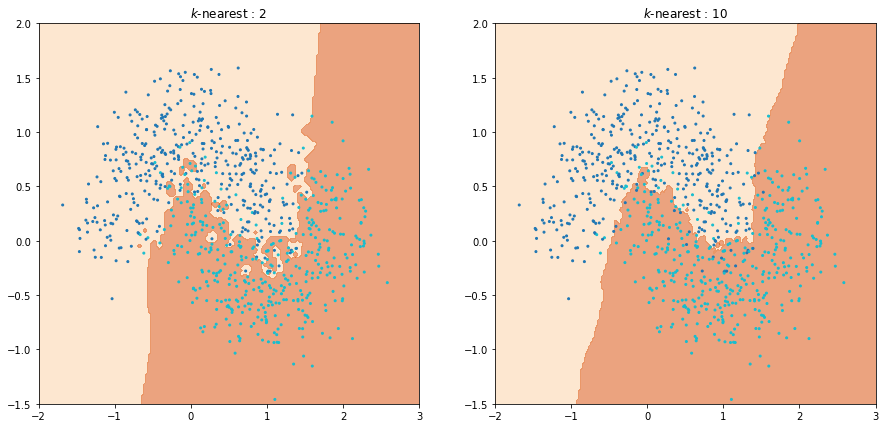

In [19]:
fig, ax = plt.subplots(1,2,figsize = (15,7))

plot_contourf(ax[0], train_x, train_y, valid_x, n_nearest = 2)
ax[0].scatter(data = train_df, x = 'x1', y = 'x2', c = 'y', cmap = 'tab10', s = 4)

plot_contourf(ax[1], train_x, train_y, valid_x, n_nearest = 10)
ax[1].scatter(data = train_df, x = 'x1', y = 'x2', c = 'y', cmap = 'tab10', s = 4)

fig.show()

## 2-2. $k$-Nearest Neighbors with wine datasets


In [20]:
skf = ss_kfold_fn(binary_data)
((train_x, train_y), (valid_x, valid_y)), scaler_x = next(skf)

In [21]:

scalers = []
valid_y_hat = []
valid_y = []
for (train_set, valid_set), scaler in ss_kfold_fn(binary_data):
    scalers.append(scaler)
    logits = knn_predict(*train_set, valid_set[0])
    valid_y.append(valid_set[1])
    valid_y_hat.append(knn_voting(logits))
    


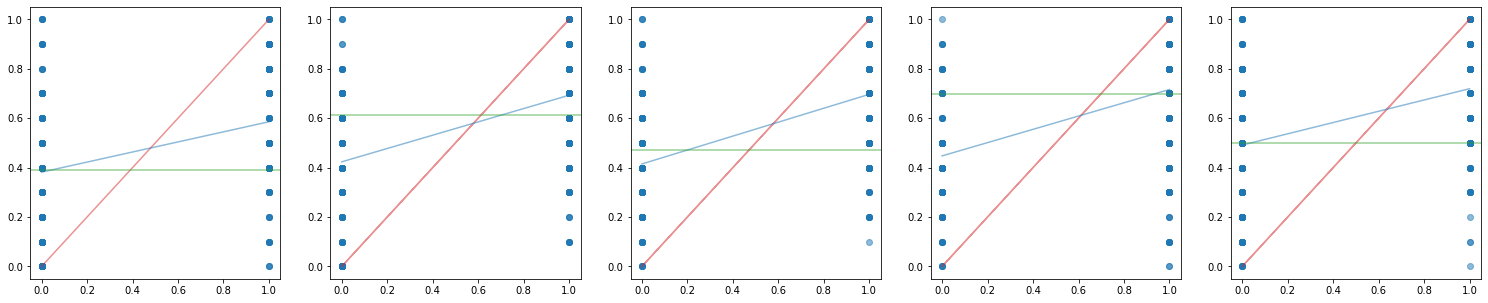

In [22]:
# 근처에 10개를 봤기 때문에 점 10개
fig, ax = plt.subplots(1,5, figsize = (26, 5))

for n, (yt, yp) in enumerate(zip(valid_y, valid_y_hat)):
    ax[n].scatter(yt, yp, alpha = .5)
    ax[n].plot(yt,yt, color = 'tab:red', alpha = .5)
    ax[n].plot([0,1],[yp[yt == 0].mean(),yp[yt == 1].mean()], color = 'tab:blue', alpha = .5)
    ax[n].axhline(yt.mean(), color = 'tab:green', alpha = .5)
    
    

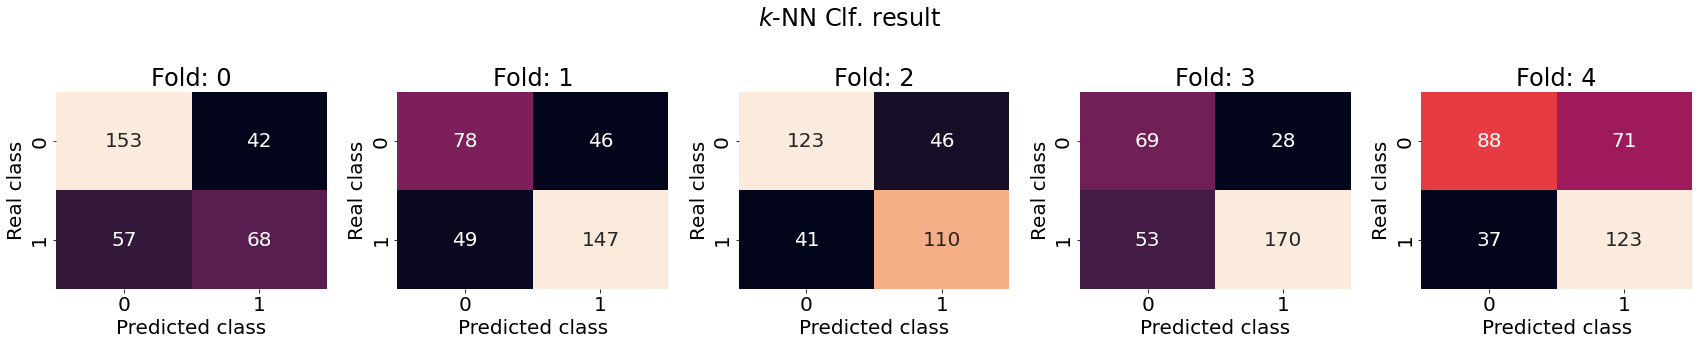

In [23]:

# knn은 k에 매우 민감하기 때문에 맞는 k를 찾아야함 -> 하이퍼 파라미터 튜닝 필요
plt.rcParams['font.size'] = 20
fig, ax = plt.subplots(1,5,figsize = (24,5))

for n, (yt, yp) in enumerate(zip(valid_y, valid_y_hat)):
    matrix = vis_clf(yt, yp)
    sbn.heatmap(matrix, ax = ax[n], cbar = False, annot = matrix, fmt = '.0f')
    ax[n].set_title(f'Fold: {n}')
    ax[n].set_ylabel('Real class')
    ax[n].set_xlabel('Predicted class')

fig.suptitle('$k$-NN Clf. result')    
fig.tight_layout()
